## Cargamos librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import SVG

from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from keras.layers import Input, Dense, SimpleRNN, Dropout, Embedding, Flatten
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from keras.optimizers import Nadam

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import string
import tensorflow as tf

tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=4))
pd.set_option('max_colwidth', 1000)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv("sentiment.txt", sep="\t", header=None )

In [3]:
df.columns=["label", "text"]

In [4]:
df.head()

,label,text
0,1,The Da Vinci Code book is just awesome.
1,1,"this was the first clive cussler i've ever read, but even books like Relic, and Da Vinci code were more plausible than this."
2,1,i liked the Da Vinci Code a lot.
3,1,i liked the Da Vinci Code a lot.
4,1,I liked the Da Vinci Code but it ultimatly didn't seem to hold it's own.


Quitamos signos de puntuación

In [5]:

#df["text"] = df["text"].str.replace("[{}]".format(string.punctuation), "")
df["text"] = df["text"].str.replace('[^\w\s]','')

In [6]:
df.head()

,label,text
0,1,The Da Vinci Code book is just awesome
1,1,this was the first clive cussler ive ever read but even books like Relic and Da Vinci code were more plausible than this
2,1,i liked the Da Vinci Code a lot
3,1,i liked the Da Vinci Code a lot
4,1,I liked the Da Vinci Code but it ultimatly didnt seem to hold its own


In [7]:
df.iloc[30,:]

label                                    1
text     Book  s  I love The Da Vinci Code
Name: 30, dtype: object

Como el df está ordenado por sentimiento positivo y negativo, lo "desordenamos"

In [8]:
df = df.sample(frac=1).reset_index(drop=True)

In [9]:
df.head()

,label,text
0,1,I either LOVE Brokeback Mountain or think its great that homosexuality is becoming more acceptable
1,1,Brokeback Mountain was so awesome
2,0,Then snuck into Brokeback Mountain which is the most depressing movie I have ever seen
3,1,the story of Harry Potter is a deep and profound one and I love Harry Potter
4,0,she helped me bobbypin my insanely cool hat to my head and she laughed at my stupid brokeback mountain cowboy jokes


In [10]:
text_df= df.text

In [11]:
text_df

0                                                                                                         I either LOVE Brokeback Mountain or think its great that homosexuality is becoming more acceptable
1                                                                                                                                                                          Brokeback Mountain was so awesome
2                                                                                                                     Then snuck into Brokeback Mountain which is the most depressing movie I have ever seen
3                                                                                                                               the story of Harry Potter is a deep and profound one and I love Harry Potter
4                                                                                        she helped me bobbypin my insanely cool hat to my head and she laughed at my stupid brokeba

Convertimos palabras a números

In [12]:
max_palabras=2500 #2235 palabras
tokenizer = Tokenizer(num_words=max_palabras)
tokenizer.fit_on_texts(text_df)
sequences = tokenizer.texts_to_sequences(text_df)

In [13]:
len(tokenizer.word_index)

2235

In [14]:
sequences

[[1, 170, 11, 8, 9, 46, 58, 61, 127, 22, 211, 12, 187, 105, 188],
 [8, 9, 14, 27, 15],
 [101, 189, 50, 8, 9, 51, 12, 2, 110, 64, 20, 1, 89, 122, 128],
 [2, 79, 31, 5, 4, 12, 13, 212, 3, 213, 41, 3, 1, 11, 5, 4],
 [81,
  214,
  56,
  215,
  29,
  216,
  150,
  190,
  19,
  29,
  191,
  3,
  81,
  217,
  99,
  29,
  34,
  8,
  9,
  192,
  193],
 [1, 350, 71, 5, 4],
 [2, 7, 6, 10, 14, 15],
 [2, 7, 6, 10, 14, 15],
 [1, 26, 5, 4, 93],
 [1, 58, 57, 931, 29, 932, 22, 140, 933, 3, 2, 7, 6, 10, 24],
 [1, 26, 5, 4],
 [8, 9, 14, 54, 15, 20],
 [7, 6, 10, 24],
 [1, 170, 11, 8, 9, 46, 58, 61, 127, 22, 211, 12, 187, 105, 188],
 [27,
  28,
  218,
  171,
  12,
  219,
  2,
  194,
  220,
  221,
  29,
  222,
  3,
  55,
  223,
  45,
  18,
  176,
  17,
  16],
 [7, 6, 10, 25],
 [7, 6, 10, 14, 54, 15, 20],
 [81,
  214,
  56,
  215,
  29,
  216,
  150,
  190,
  19,
  29,
  191,
  3,
  81,
  217,
  99,
  29,
  34,
  8,
  9,
  192,
  193],
 [2, 79, 31, 5, 4, 12, 13, 212, 3, 213, 41, 3, 1, 11, 5, 4],
 [1, 120, 7,

Y rellenamos con "0"

In [15]:
seq_len_max =100
text_df_seq = pad_sequences(sequences, maxlen=seq_len_max )

In [16]:
text_df_seq

array([[  0,   0,   0, ..., 187, 105, 188],
       [  0,   0,   0, ...,  14,  27,  15],
       [  0,   0,   0, ...,  89, 122, 128],
       ...,
       [  0,   0,   0, ...,  11,   8,   9],
       [  0,   0,   0, ...,  18,  17,  16],
       [  0,   0,   0, ..., 256, 257, 157]])

In [17]:
np.shape(text_df_seq)

(6918, 100)

Creamos las muestras de entrenamiento, validación y test

In [18]:
print(6918*.6, 6918*.8) #entrenamiento 70%, validación 15%, test 15%

4150.8 5534.400000000001


In [19]:
X_train = text_df_seq[0:4150,]
X_val = text_df_seq[4150:5534,]
X_test = text_df_seq[5534:,]


In [20]:
np.shape(X_train)

(4150, 100)

In [21]:
np.shape(X_val)

(1384, 100)

In [22]:
np.shape(X_test)

(1384, 100)

In [23]:
y_train = df.label[0:4150,]
y_val = df.label[4150:5534,]
y_test = df.label[5534:,]

In [24]:
np.shape(y_train)

(4150,)

In [25]:
np.shape(y_val)

(1384,)

In [26]:
np.shape(y_test)

(1384,)

## Red Secuencial

Creamos la arquitectura en una función

In [27]:
def create_model(units_RNN = 1):
    model_input = Input(shape=(seq_len_max,), dtype='int32')
    embedded_layer = Embedding(len(tokenizer.word_index)+1, 100, embeddings_initializer='uniform')(model_input)
    recu_layer = SimpleRNN(units=units_RNN, activation='tanh', use_bias=True) (embedded_layer)
   
    model_ouput = Dense(1, activation='sigmoid')(recu_layer)

    model = Model(model_input, model_ouput)
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])


    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          223600    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 1)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 223,704
Trainable params: 223,704
Non-trainable params: 0
_________________________________________________________________
None


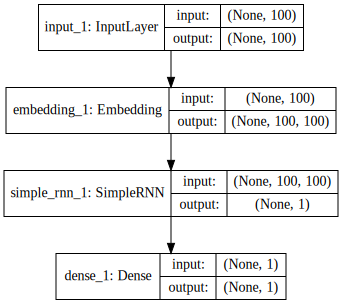

In [28]:
modelo=create_model()

print(modelo.summary())
SVG(model_to_dot(modelo,show_shapes=True).create(prog='dot', format='svg'))

Entrenamos

In [29]:
modelo.fit(X_train, y_train, validation_data=(X_val, y_val),
          epochs=10, batch_size=128)

Train on 4150 samples, validate on 1384 samples
Epoch 1/10
4150/4150 [==============================] - 2s 367us/step - loss: 0.4833 - acc: 0.8766 - val_loss: 0.4230 - val_acc: 0.8945
Epoch 2/10
4150/4150 [==============================] - 1s 309us/step - loss: 0.3793 - acc: 0.9277 - val_loss: 0.3675 - val_acc: 0.9227
Epoch 3/10
4150/4150 [==============================] - 1s 330us/step - loss: 0.3350 - acc: 0.9492 - val_loss: 0.3389 - val_acc: 0.9314
Epoch 4/10
4150/4150 [==============================] - 1s 318us/step - loss: 0.3087 - acc: 0.9586 - val_loss: 0.3230 - val_acc: 0.9342
Epoch 5/10
4150/4150 [==============================] - 1s 308us/step - loss: 0.2907 - acc: 0.9634 - val_loss: 0.3131 - val_acc: 0.9350
Epoch 6/10
4150/4150 [==============================] - 1s 301us/step - loss: 0.2768 - acc: 0.9677 - val_loss: 0.3061 - val_acc: 0.9357
Epoch 7/10
4150/4150 [==============================] - 1s 300us/step - loss: 0.2645 - acc: 0.9718 - val_loss: 0.2979 - val_acc: 0.9422


Evaluamos el modelo

In [30]:
modelo.evaluate(X_test, y_test)

1384/1384 [==============================] - 0s 179us/step


[0.2711401714410396, 0.9450867052023122]

In [31]:
X_test

array([[  0,   0,   0, ...,   9,  14,  15],
       [  0,   0,   0, ...,  13,  92,  87],
       [  0,   0,   0, ...,  27,  30, 175],
       ...,
       [  0,   0,   0, ...,  11,   8,   9],
       [  0,   0,   0, ...,  18,  17,  16],
       [  0,   0,   0, ..., 256, 257, 157]])

In [32]:
y_pred_proba = modelo.predict(X_test)
y_pred = np.round(y_pred_proba)
print('')
print(classification_report(y_test, y_pred))


             precision    recall  f1-score   support

          0       0.93      0.94      0.94       587
          1       0.95      0.95      0.95       797

avg / total       0.95      0.95      0.95      1384



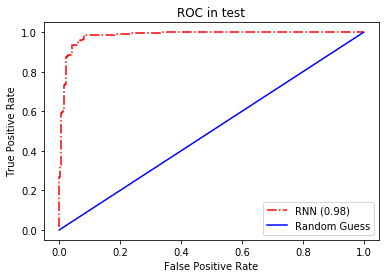

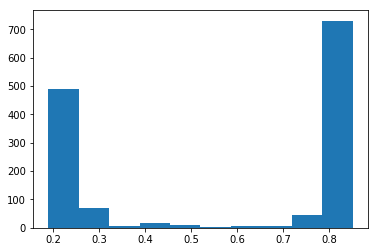

In [33]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'RNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC in test')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend()
plt.show()
plt.hist(y_pred_proba)
plt.show()

El modelo presenta un gran poder predictivo
Con sólo una unidad RNN ya tiene un gran poder predictivo:

             precision    recall  f1-score   support

          0       0.98      0.97      0.97       579
          1       0.98      0.99      0.98       805

      total(avg)  0.98      0.98      0.98      1384

Ahora vamos a probar con 5 unidades

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 100)          223600    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 5)                 530       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 224,136
Trainable params: 224,136
Non-trainable params: 0
_________________________________________________________________
None


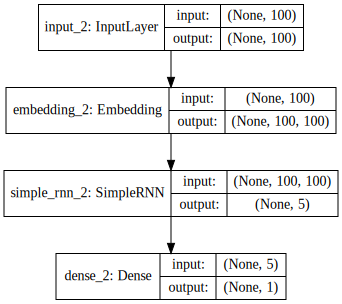

In [34]:
modelo=create_model(5)

print(modelo.summary())
SVG(model_to_dot(modelo,show_shapes=True).create(prog='dot', format='svg'))

Entrenamos

In [35]:
modelo.fit(X_train, y_train, validation_data=(X_val, y_val),
          epochs=10, batch_size=128)

Train on 4150 samples, validate on 1384 samples
Epoch 1/10
4150/4150 [==============================] - 2s 376us/step - loss: 0.4527 - acc: 0.8858 - val_loss: 0.3560 - val_acc: 0.9227
Epoch 2/10
4150/4150 [==============================] - 1s 320us/step - loss: 0.2910 - acc: 0.9573 - val_loss: 0.2615 - val_acc: 0.9465
Epoch 3/10
4150/4150 [==============================] - 1s 358us/step - loss: 0.2118 - acc: 0.9759 - val_loss: 0.2039 - val_acc: 0.9545
Epoch 4/10
4150/4150 [==============================] - 1s 354us/step - loss: 0.1617 - acc: 0.9831 - val_loss: 0.1706 - val_acc: 0.9559
Epoch 5/10
4150/4150 [==============================] - 1s 355us/step - loss: 0.1282 - acc: 0.9855 - val_loss: 0.1481 - val_acc: 0.9581
Epoch 6/10
4150/4150 [==============================] - 1s 355us/step - loss: 0.1041 - acc: 0.9875 - val_loss: 0.1293 - val_acc: 0.9632
Epoch 7/10
4150/4150 [==============================] - 1s 356us/step - loss: 0.0862 - acc: 0.9899 - val_loss: 0.1168 - val_acc: 0.9653


Evaluamos el modelo

In [36]:
modelo.evaluate(X_test, y_test)

1384/1384 [==============================] - 0s 226us/step


[0.08545893025880603, 0.9754335260115607]

In [37]:
X_test

array([[  0,   0,   0, ...,   9,  14,  15],
       [  0,   0,   0, ...,  13,  92,  87],
       [  0,   0,   0, ...,  27,  30, 175],
       ...,
       [  0,   0,   0, ...,  11,   8,   9],
       [  0,   0,   0, ...,  18,  17,  16],
       [  0,   0,   0, ..., 256, 257, 157]])

In [38]:
y_pred_proba = modelo.predict(X_test)
y_pred = np.round(y_pred_proba)
print('')
print(classification_report(y_test, y_pred))


             precision    recall  f1-score   support

          0       0.97      0.97      0.97       587
          1       0.98      0.98      0.98       797

avg / total       0.98      0.98      0.98      1384



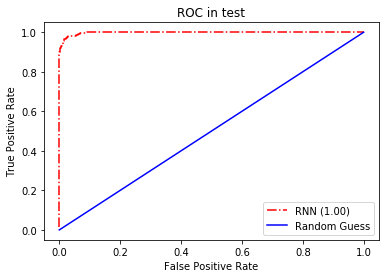

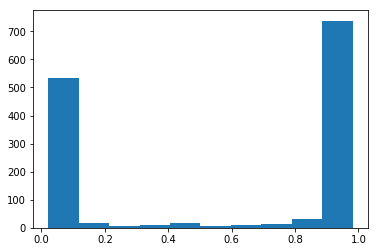

In [39]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'RNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC in test')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend()
plt.show()
plt.hist(y_pred_proba)
plt.show()

Con cinco unidades RNN el modelo empeora luego, como pasa en muchas ocasiones un modelo más simple fuciona mejor que uno más complejo...
Pero ¿qué pasa si usamos un Perceptron Multicapa?

In [47]:
def create_model2(units_dense = 1):
    model_input = Input(shape=(seq_len_max,), dtype='int32')
    embedded_layer = Embedding(len(tokenizer.word_index)+1, 100, embeddings_initializer='uniform')(model_input)
    embedded_layer = Flatten()(embedded_layer)
    dense = Dense(units=units_dense, activation='tanh', use_bias=True) (embedded_layer)
   
   
    model_ouput = Dense(1, activation='sigmoid')(dense)

    model = Model(model_input, model_ouput)
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])


    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 100, 100)          223600    
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 20002     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 3         
Total params: 243,605
Trainable params: 243,605
Non-trainable params: 0
_________________________________________________________________
None


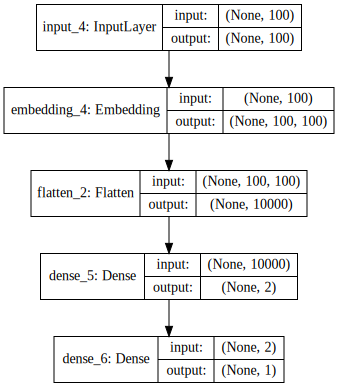

In [48]:
modelo=create_model2(2)

print(modelo.summary())
SVG(model_to_dot(modelo,show_shapes=True).create(prog='dot', format='svg'))

Entrenamos

In [49]:
modelo.fit(X_train, y_train, validation_data=(X_val, y_val),
          epochs=10, batch_size=128)

Train on 4150 samples, validate on 1384 samples
Epoch 1/10
4150/4150 [==============================] - 1s 146us/step - loss: 0.5419 - acc: 0.7993 - val_loss: 0.4152 - val_acc: 0.8829
Epoch 2/10
4150/4150 [==============================] - 0s 84us/step - loss: 0.3419 - acc: 0.9439 - val_loss: 0.3089 - val_acc: 0.9552
Epoch 3/10
4150/4150 [==============================] - 0s 83us/step - loss: 0.2656 - acc: 0.9713 - val_loss: 0.2608 - val_acc: 0.9595
Epoch 4/10
4150/4150 [==============================] - 0s 82us/step - loss: 0.2228 - acc: 0.9831 - val_loss: 0.2270 - val_acc: 0.9668
Epoch 5/10
4150/4150 [==============================] - 0s 82us/step - loss: 0.1945 - acc: 0.9901 - val_loss: 0.2050 - val_acc: 0.9754
Epoch 6/10
4150/4150 [==============================] - 0s 80us/step - loss: 0.1740 - acc: 0.9945 - val_loss: 0.1905 - val_acc: 0.9747
Epoch 7/10
4150/4150 [==============================] - 0s 79us/step - loss: 0.1583 - acc: 0.9969 - val_loss: 0.1754 - val_acc: 0.9827
Epoch 

Evaluamos el modelo

In [50]:
modelo.evaluate(X_test, y_test)

1384/1384 [==============================] - 0s 43us/step


[0.14733835262370248, 0.9848265895953757]

In [51]:
X_test

array([[  0,   0,   0, ...,   9,  14,  15],
       [  0,   0,   0, ...,  13,  92,  87],
       [  0,   0,   0, ...,  27,  30, 175],
       ...,
       [  0,   0,   0, ...,  11,   8,   9],
       [  0,   0,   0, ...,  18,  17,  16],
       [  0,   0,   0, ..., 256, 257, 157]])

In [52]:
y_pred_proba = modelo.predict(X_test)
y_pred = np.round(y_pred_proba)
print('')
print(classification_report(y_test, y_pred))


             precision    recall  f1-score   support

          0       0.99      0.98      0.98       587
          1       0.98      0.99      0.99       797

avg / total       0.98      0.98      0.98      1384



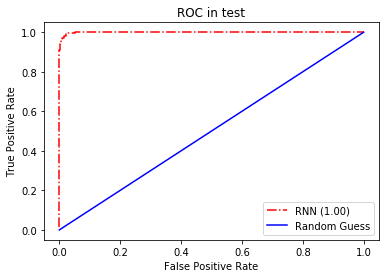

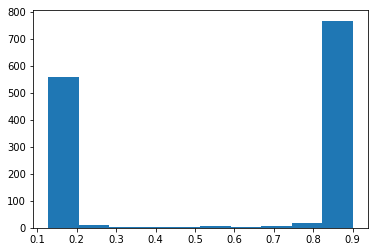

In [53]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'RNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC in test')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend()
plt.show()
plt.hist(y_pred_proba)
plt.show()

En este caso al ser un modelo de juguete (toy model) y unos datos de juguete tanbién da buenos resultados. Tengo la sensación que la capa de "Embedding" facilita mucho el trabajo y es parte del éxito del modelo

Ahora probaremos directamente la capa Embedding conectada a la sigmoid

In [55]:
def create_model3():
    model_input = Input(shape=(seq_len_max,), dtype='int32')
    embedded_layer = Embedding(len(tokenizer.word_index)+1, 100, embeddings_initializer='uniform')(model_input)
    embedded_layer = Flatten()(embedded_layer)

     
    model_ouput = Dense(1, activation='sigmoid')(embedded_layer)

    model = Model(model_input, model_ouput)
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])


    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 100, 100)          223600    
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 10001     
Total params: 233,601
Trainable params: 233,601
Non-trainable params: 0
_________________________________________________________________
None


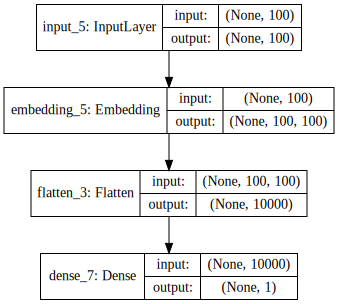

In [56]:
modelo=create_model3()

print(modelo.summary())
SVG(model_to_dot(modelo,show_shapes=True).create(prog='dot', format='svg'))

Entrenamos

In [57]:
modelo.fit(X_train, y_train, validation_data=(X_val, y_val),
          epochs=10, batch_size=128)

Train on 4150 samples, validate on 1384 samples
Epoch 1/10
4150/4150 [==============================] - 0s 119us/step - loss: 0.5603 - acc: 0.7617 - val_loss: 0.4277 - val_acc: 0.8447
Epoch 2/10
4150/4150 [==============================] - 0s 56us/step - loss: 0.3126 - acc: 0.9243 - val_loss: 0.2610 - val_acc: 0.8837
Epoch 3/10
4150/4150 [==============================] - 0s 58us/step - loss: 0.1830 - acc: 0.9480 - val_loss: 0.1645 - val_acc: 0.9501
Epoch 4/10
4150/4150 [==============================] - 0s 59us/step - loss: 0.1181 - acc: 0.9728 - val_loss: 0.1214 - val_acc: 0.9581
Epoch 5/10
4150/4150 [==============================] - 0s 56us/step - loss: 0.0805 - acc: 0.9805 - val_loss: 0.0973 - val_acc: 0.9595
Epoch 6/10
4150/4150 [==============================] - 0s 58us/step - loss: 0.0561 - acc: 0.9855 - val_loss: 0.0772 - val_acc: 0.9668
Epoch 7/10
4150/4150 [==============================] - 0s 62us/step - loss: 0.0397 - acc: 0.9906 - val_loss: 0.0645 - val_acc: 0.9733
Epoch 

Evaluamos el modelo

In [58]:
modelo.evaluate(X_test, y_test)

1384/1384 [==============================] - 0s 30us/step


[0.05423714882139698, 0.9747109826589595]

In [59]:
X_test

array([[  0,   0,   0, ...,   9,  14,  15],
       [  0,   0,   0, ...,  13,  92,  87],
       [  0,   0,   0, ...,  27,  30, 175],
       ...,
       [  0,   0,   0, ...,  11,   8,   9],
       [  0,   0,   0, ...,  18,  17,  16],
       [  0,   0,   0, ..., 256, 257, 157]])

In [60]:
y_pred_proba = modelo.predict(X_test)
y_pred = np.round(y_pred_proba)
print('')
print(classification_report(y_test, y_pred))


             precision    recall  f1-score   support

          0       0.97      0.97      0.97       587
          1       0.98      0.97      0.98       797

avg / total       0.97      0.97      0.97      1384



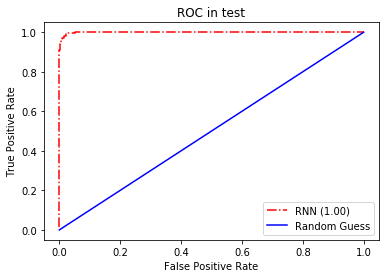

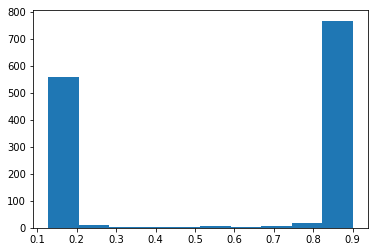

In [53]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'RNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC in test')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend()
plt.show()
plt.hist(y_pred_proba)
plt.show()

Con este último modelo se confirma que el uso directo de la sigmoide es suficiente para entrenar